In [1]:
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 120
import pandas as pd
import numpy as np

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


#### Define CNN

In [3]:
# Parameters
learning_rate = 0.1
alpha = 0.0001
dropout = 0.2
momentum = 0.99
num_steps = 500
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 100
image_size = 28
num_input = image_size*image_size
num_classes = 10
filter_num = 16
filter_size = [5, 5]

In [4]:
# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout rate

In [5]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [6]:
# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [7]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [8]:
# Construct model
logits = logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# Evaluate model
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1)), tf.float32))

#### Training

In [9]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:
    metrics = {
        'train_loss':[],
        'train_acc':[],
        'test_loss':[],
        'test_acc':[]
    }
    
    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.8})
        if step % display_step == 0 or step == 1: 
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0})
            print("Step " + str(step) + " Train loss: %0.5f, Train acc: %0.5f" % (loss, acc))
            metrics['train_loss'].append(loss)
            metrics['train_acc'].append(acc)
            #loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1.0})
            #print("Step " + str(step) + " Test loss: %0.5f, Test acc: %0.5f" % (loss, acc))
            #metrics['test_loss'].append(loss)
            #metrics['test_acc'].append(acc)

    print("Optimization Finished!")

Step 1 Train loss: 61149.88281, Train acc: 0.05469
Step 100 Train loss: 2165.84668, Train acc: 0.86719
Step 200 Train loss: 998.60565, Train acc: 0.90625
Step 300 Train loss: 1188.14929, Train acc: 0.89062
Step 400 Train loss: 309.51343, Train acc: 0.96094
Step 500 Train loss: 725.41028, Train acc: 0.93750
Optimization Finished!


Text(0,0.5,'Loss')

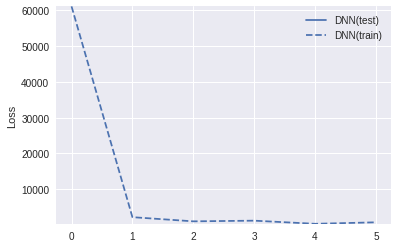

In [11]:
snc = sns.color_palette()

plt.plot(metrics['test_loss'], color=snc[0])
plt.plot(metrics['train_loss'], color=snc[0], ls='--')
plt.ylim(min(metrics['train_loss']), max(metrics['train_loss']))
plt.legend(['DNN(test)', 'DNN(train)'])
plt.ylabel('Loss')